<a href="https://www.kaggle.com/code/rubanzasilva/s5e7-fastai-gradient-boosting?scriptVersionId=253262281" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Personality Type Binary Classification

Our goal for this competition is to predict whether a person is an Introvert or Extrovert, given their social behavior and personality traits.

## Data & Library Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv
/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv
/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv


In [2]:
%%time
%pip install catboost
%pip install optuna
#%pip install optuna_distributed
#%pip install openfe
%pip install seaborn
%pip install xgboost
%pip install lightgbm
%pip install fastkaggle
#%pip install h2o
%pip install -Uqq fastbook
#%pip install polars
#%pip install -q -U autogluon.tabular
#%pip install autogluon
%pip install --upgrade pip
%pip install tqdm
#%pip install wandb
#%pip install sweetviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.1/124.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm

#import fastbook
#fastbook.setup_book()
#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
np.set_printoptions(linewidth=130)


from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score,train_test_split,GridSearchCV


from pathlib import Path
import os

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier,Pool, metrics, cv


import warnings


#from openfe import OpenFE, transform
#from autogluon.tabular import TabularDataset, TabularPredictor

#import h2o
#from h2o.automl import H2OAutoML

import gc

import optuna
from optuna.samplers import TPESampler

import pickle
from joblib import dump, load
#import sweetviz as sv
#from IPython.display import FileLink

#import h2o
#from h2o.automl import H2OAutoML

In [4]:
#torch.manual_seed(42)

In [5]:
path = Path('/kaggle/input/playground-series-s5e7/')
path

Path('/kaggle/input/playground-series-s5e7')

In [6]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')
original_df_a = pd.read_csv('/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv')
original_df_b = pd.read_csv('/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv')

In [7]:
train_df.shape,original_df_a.shape,original_df_b.shape

((18524, 8), (2900, 8), (2900, 8))

In [8]:
original_df_b

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert
...,...,...,...,...,...,...,...,...
2895,3.0,No,7.0,6.0,No,6.0,6.0,Extrovert
2896,3.0,No,8.0,3.0,No,14.0,9.0,Extrovert
2897,4.0,Yes,1.0,1.0,Yes,4.0,0.0,Introvert
2898,11.0,Yes,1.0,3.0,Yes,2.0,0.0,Introvert


In [9]:
#train_df = pd.concat([train_df, original_df], ignore_index=True)

## Exploratory Data Analysis

In [10]:
train_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [11]:
# Transpose to see data vertically
train_df.head().T

id,0,1,2,3,4
Time_spent_Alone,0.0,1.0,6.0,3.0,1.0
Stage_fear,No,No,Yes,No,No
Social_event_attendance,6.0,7.0,1.0,7.0,4.0
Going_outside,4.0,3.0,0.0,3.0,4.0
Drained_after_socializing,No,No,NaN,No,No
Friends_circle_size,15.0,10.0,3.0,11.0,13.0
Post_frequency,5.0,8.0,0.0,5.0,NaN
Personality,Extrovert,Extrovert,Introvert,Extrovert,Extrovert


In [12]:
train_df.columns, original_df_a.columns

(Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
        'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
        'Post_frequency', 'Personality'],
       dtype='object'),
 Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
        'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
        'Post_frequency', 'Personality'],
       dtype='object'))

#### Missing value check

In [13]:
missing_values_count = train_df.isnull().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
print(sorted_missing_values)

Stage_fear                   1893
Going_outside                1466
Post_frequency               1264
Time_spent_Alone             1190
Social_event_attendance      1180
Drained_after_socializing    1149
Friends_circle_size          1054
Personality                     0
dtype: int64


In [14]:
#Missing values returned as percentages.
missing_percentages = train_df.isnull().mean() * 100
sorted_missing_percentages = missing_percentages.sort_values(ascending=False)
print(sorted_missing_percentages)

Stage_fear                   10.219175
Going_outside                 7.914057
Post_frequency                6.823580
Time_spent_Alone              6.424098
Social_event_attendance       6.370114
Drained_after_socializing     6.202764
Friends_circle_size           5.689916
Personality                   0.000000
dtype: float64


#### Summary Statistics

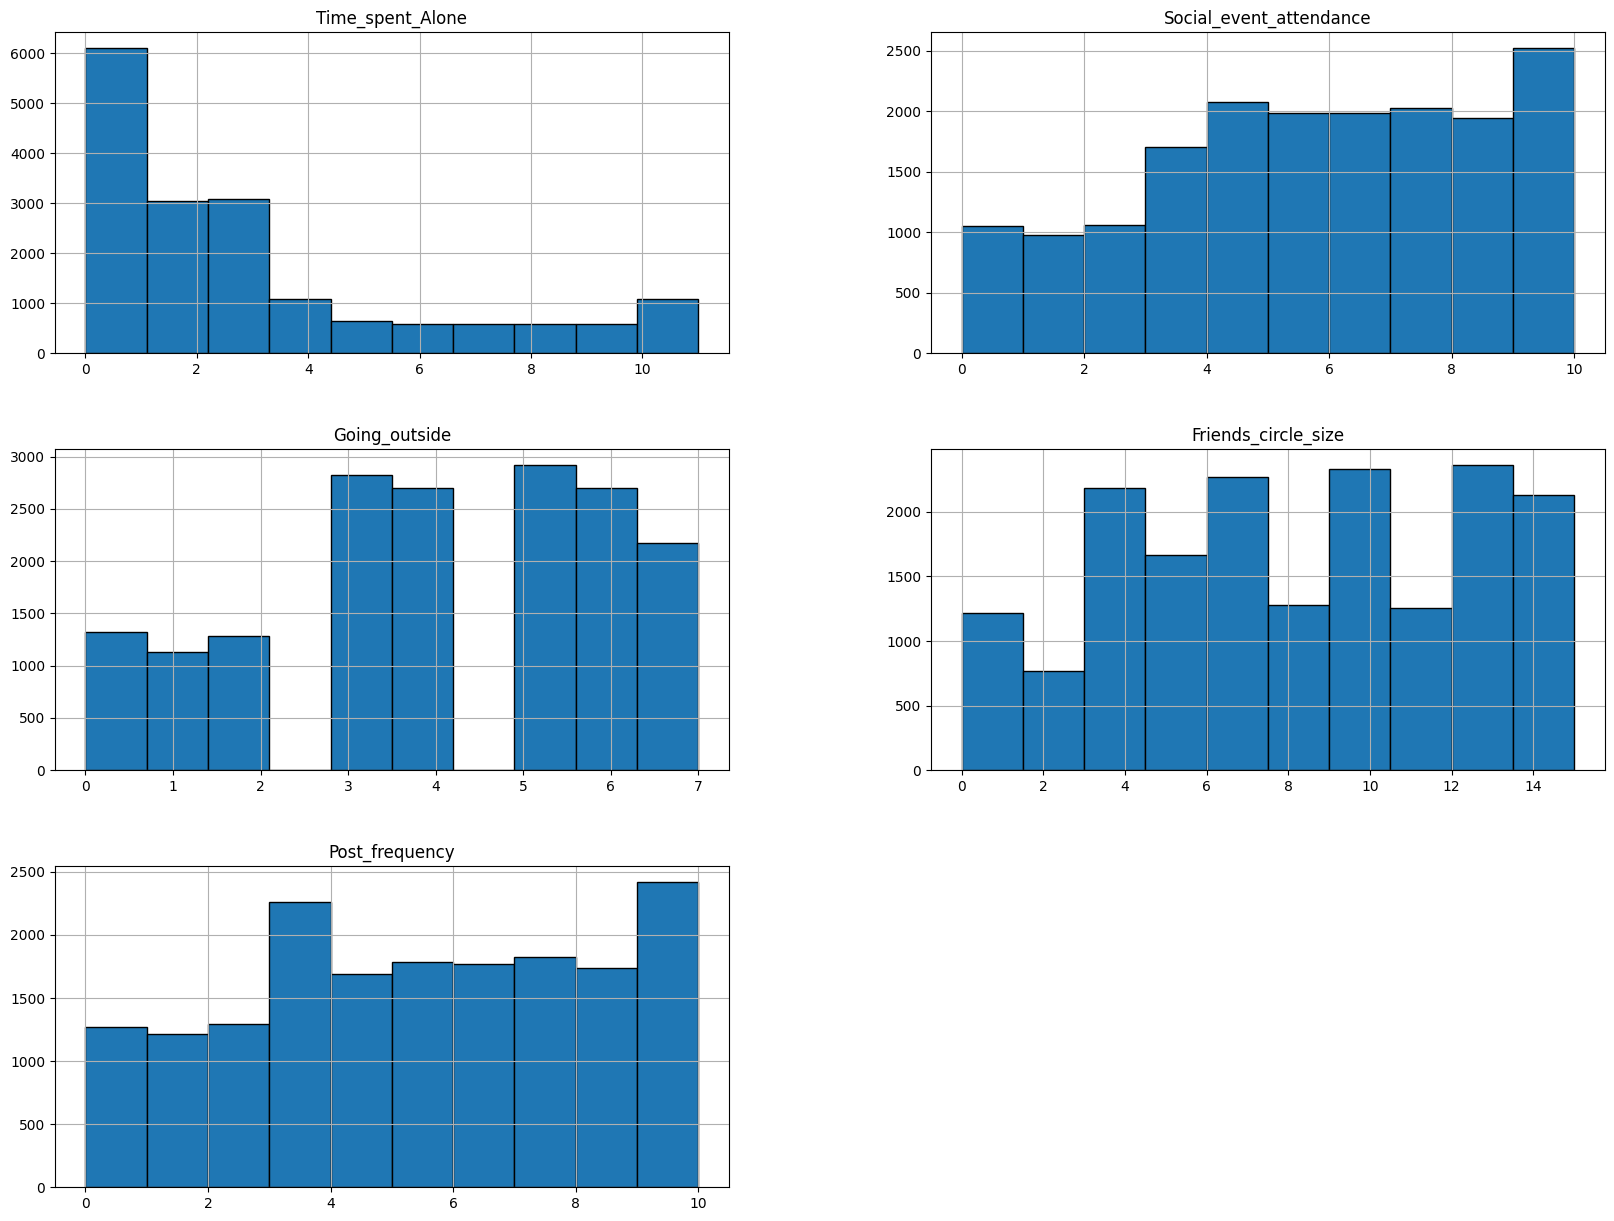

In [15]:
train_df.hist(figsize=(20,15),edgecolor='black');

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.3+ MB


In [17]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time_spent_Alone,17334.0,3.137764,3.003786,0.0,1.0,2.0,4.0,11.0
Social_event_attendance,17344.0,5.265106,2.753359,0.0,3.0,5.0,8.0,10.0
Going_outside,17058.0,4.044319,2.062580,0.0,3.0,4.0,6.0,7.0
Friends_circle_size,17470.0,7.996737,4.223484,0.0,5.0,8.0,12.0,15.0
Post_frequency,17260.0,4.982097,2.879139,0.0,3.0,5.0,7.0,10.0


#### Target Variable

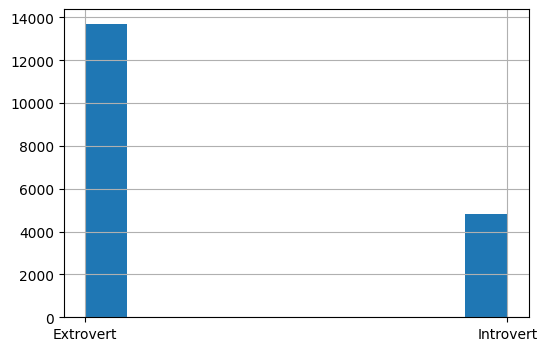

In [18]:
train_df['Personality'].hist(figsize=(6,4));

In [19]:
def cat_plot_count_dist(data, column, title=None, figsize=(15,10)):
    plt.figure(figsize=figsize)
    ax = sns.countplot(x=column, data=data)
    
    # Set title (use column name if title not provided)
    title = title or f'Distribution by {column}'
    plt.title(title, fontsize=16)
    
    # Set labels
    plt.xlabel(column, fontsize=16)
    plt.ylabel('Count', fontsize=16)
    
    # Set tick sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add value labels on bars
    for i in ax.containers:
        ax.bar_label(i, fontsize=14, padding=10)
        
    plt.tight_layout()
    plt.show()

In [20]:
def plot_pie_distribution(data, column, explode=None, figsize=(6,6), title=None):
   # Get value counts
   counts = data[column].value_counts()
   
   # Set default explode if not provided 
   if explode is None:
       explode = tuple([0] * len(counts))
   
   # Set default title if not provided
   title = title or f'Distribution of {column}'
   
   plt.figure(figsize=figsize)
   plt.pie(counts.values, labels=counts.index,
           explode=explode, autopct='%1.1f%%', startangle=90)
   plt.axis('equal')
   plt.title(title, fontsize=16)
   plt.show()

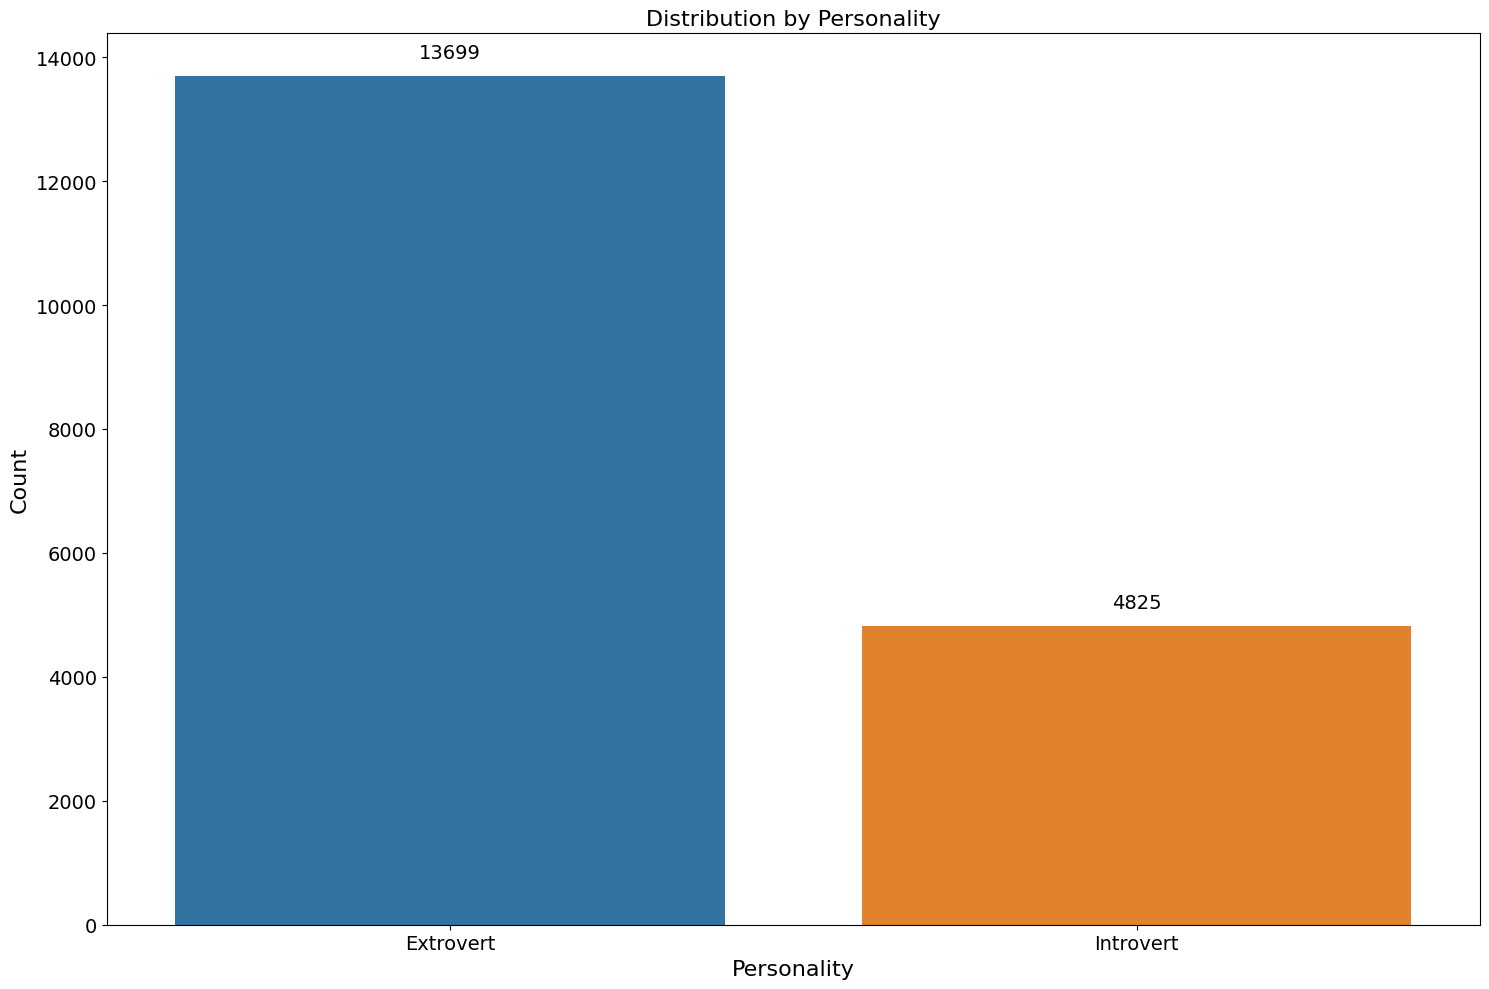

In [21]:
#cat_plot_count_dist(train_df, 'Depression', figsize=(12,8))
cat_plot_count_dist(train_df, 'Personality', 'Distribution by Personality')

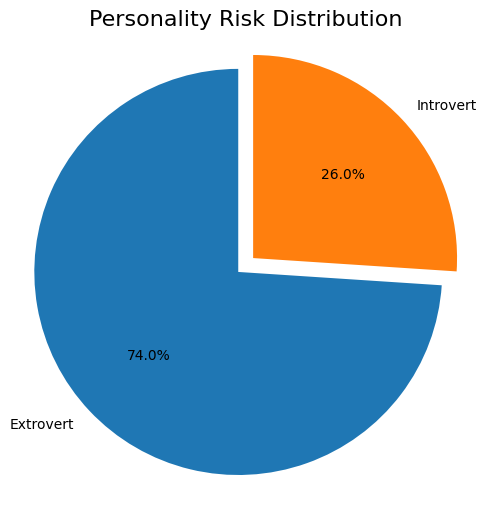

In [22]:
plot_pie_distribution(train_df, 'Personality', 
                    explode=(0,0.1), 
                    title='Personality Risk Distribution')

#### Univariate Analysis

In [23]:
train_df.describe(include=[object]).T

,count,unique,top,freq
Stage_fear,16631,2,No,12609
Drained_after_socializing,17375,2,No,13313
Personality,18524,2,Extrovert,13699


##### Stage_fear

In [24]:
train_df['Stage_fear'].nunique()

2

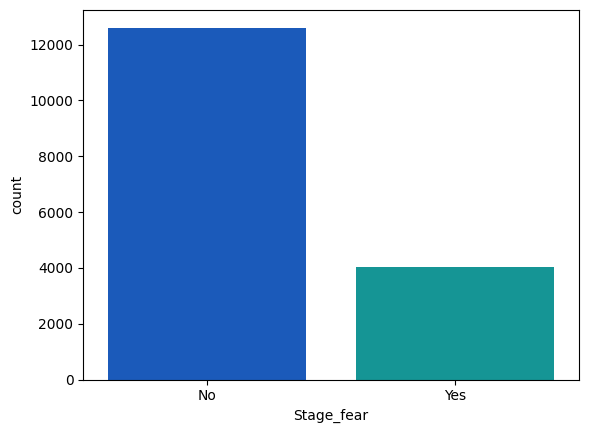

In [25]:
sns.countplot(x='Stage_fear', data=train_df, palette='winter')
plt.show()

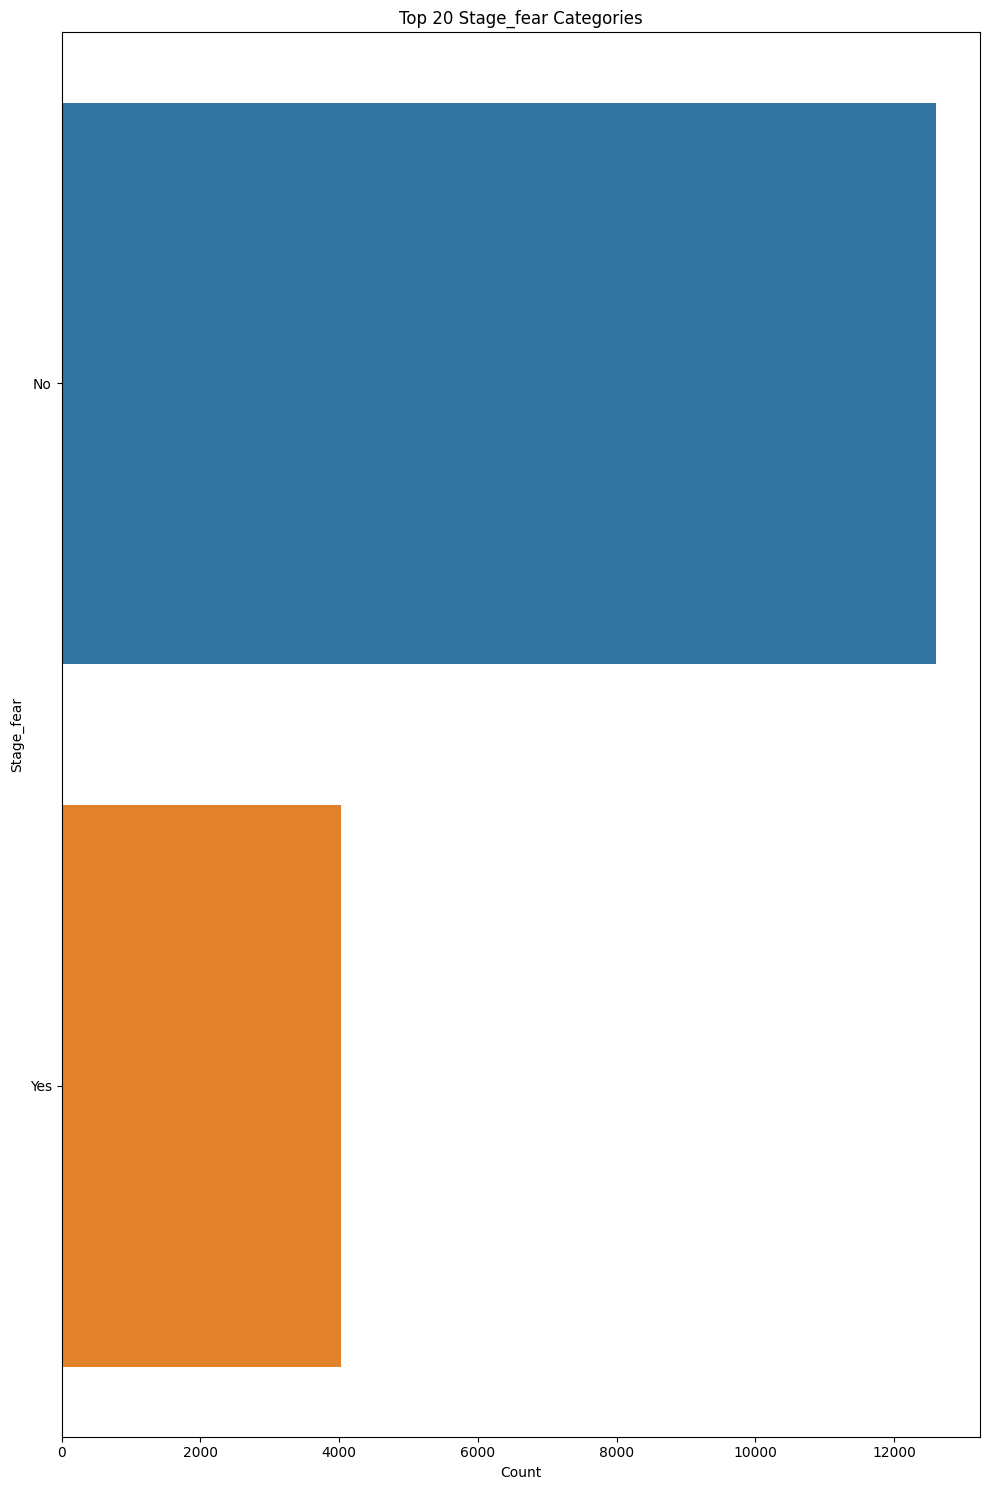

In [26]:
def plot_top_categories(data, column, top_n=20, figsize=(10,15)):
    # Get value counts and take top N
    top_values = data[column].value_counts().head(top_n)
    
    plt.figure(figsize=figsize)
    sns.barplot(x=top_values.values, y=top_values.index)
    plt.title(f'Top {top_n} {column} Categories')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()


plot_top_categories(train_df, 'Stage_fear', top_n=20)

##### Drained_after_socializing

In [27]:
train_df['Drained_after_socializing'].nunique()

2

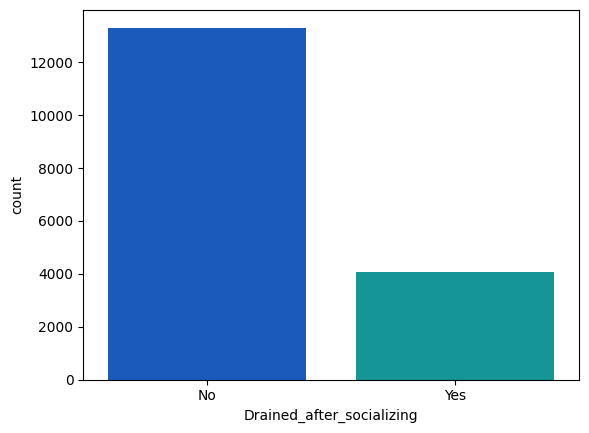

In [28]:
sns.countplot(x='Drained_after_socializing', data=train_df, palette='winter')
plt.show()

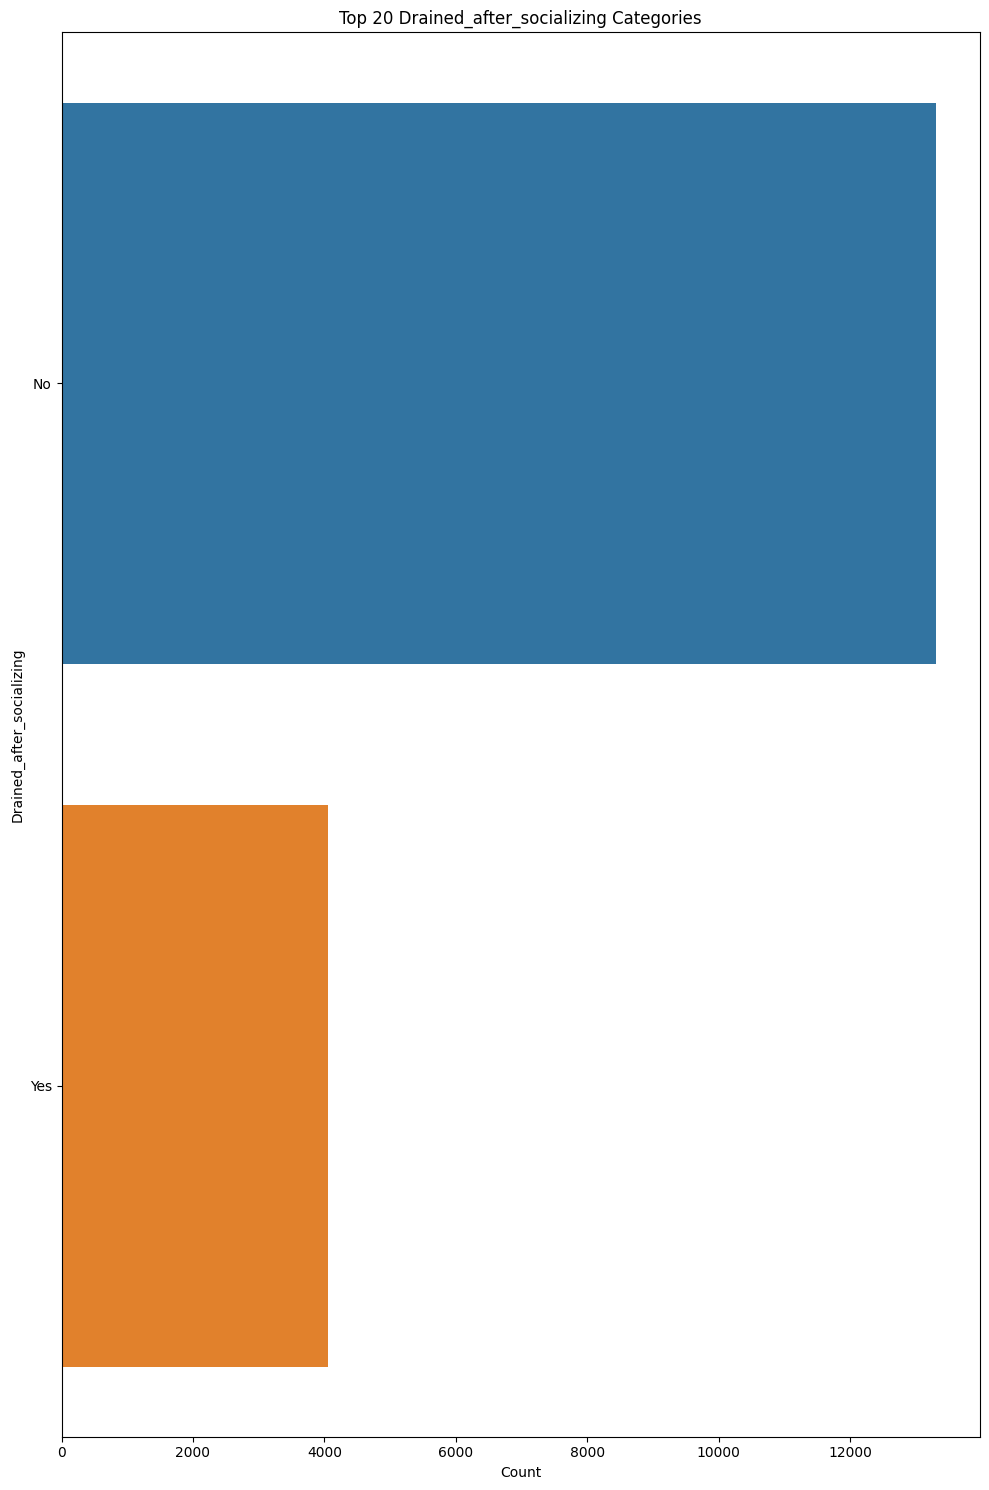

In [29]:
def plot_top_categories(data, column, top_n=20, figsize=(10,15)):
    # Get value counts and take top N
    top_values = data[column].value_counts().head(top_n)
    
    plt.figure(figsize=figsize)
    sns.barplot(x=top_values.values, y=top_values.index)
    plt.title(f'Top {top_n} {column} Categories')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()


plot_top_categories(train_df, 'Drained_after_socializing', top_n=20)

#### Continous variables

In [30]:
#train_df.value_counts()

In [31]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time_spent_Alone,17334.0,3.137764,3.003786,0.0,1.0,2.0,4.0,11.0
Social_event_attendance,17344.0,5.265106,2.753359,0.0,3.0,5.0,8.0,10.0
Going_outside,17058.0,4.044319,2.062580,0.0,3.0,4.0,6.0,7.0
Friends_circle_size,17470.0,7.996737,4.223484,0.0,5.0,8.0,12.0,15.0
Post_frequency,17260.0,4.982097,2.879139,0.0,3.0,5.0,7.0,10.0


#### Time_spent_Alone

In [32]:
train_df.Time_spent_Alone.var()

9.02273234466217

## Data Pre-processing with fast.ai

The `RandomSplitter` function below separates the training set into a training and validation set based on the value of the argument `valid_pct`.

In [33]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [34]:
#I decided to put concat the original df and the train df after doing the split so that validation can be done on the competition dataset only.
train_df = pd.concat([train_df, original_df_a], ignore_index=True)
#train_df = pd.concat(objs=[train_df, original_df])

In [35]:
train_df.shape

(21424, 8)

In [36]:
train_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
...,...,...,...,...,...,...,...,...
21419,3.0,No,7.0,6.0,No,6.0,6.0,Extrovert
21420,3.0,No,8.0,3.0,No,14.0,9.0,Extrovert
21421,4.0,Yes,1.0,1.0,Yes,4.0,0.0,Introvert
21422,11.0,Yes,1.0,NaN,Yes,2.0,0.0,Introvert


Below, we are going to prepare our data for machine learning.

First, we define the categorical and continuous variables. I use the fastai `cont_cat_split` function to separate my dataset variables into categorical and continuous variables based on the cardinality of my column values.

`cont_cat_split` takes an argument,`max_card` whose default value is 20. If the number of unique values is above 20 (the default `max_card` value) for a particular column, that column is considered continuous, and vice versa.

Define a `TabularPandas` object. Here we define the continuous and categorical columns, the dataset splitting strategy, preprocessing steps to apply to our datasets, the dependent variable, which is what we are predicting, and the type of problem we are optimizing for, such as binary classification in this case.

I then create and define a `dataloaders` object, which prepares the data for input into our neural network. Here, we also define our batch size.

In [37]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Personality')
#splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
#to = TabularPandas(train_df, procs=[Categorify,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Personality',
                   y_block=CategoryBlock(),
                   splits=splits)
dls = to.dataloaders(bs=64)
#dls = to.dataloaders(bs=1024)
test_dl = dls.test_dl(test_df)

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [38]:
cont_names,len(cont_names)

(['Time_spent_Alone',
  'Social_event_attendance',
  'Going_outside',
  'Friends_circle_size',
  'Post_frequency'],
 5)

In [39]:
cat_names, len(cat_names)

(['Stage_fear',
  'Drained_after_socializing',
  'Time_spent_Alone_na',
  'Social_event_attendance_na',
  'Going_outside_na',
  'Friends_circle_size_na',
  'Post_frequency_na'],
 7)

In [40]:
train_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
...,...,...,...,...,...,...,...,...
21419,3.0,No,7.0,6.0,No,6.0,6.0,Extrovert
21420,3.0,No,8.0,3.0,No,14.0,9.0,Extrovert
21421,4.0,Yes,1.0,1.0,Yes,4.0,0.0,Introvert
21422,11.0,Yes,1.0,NaN,Yes,2.0,0.0,Introvert


Finally, I extract the training and validation sets plus their values.

In [41]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

### Define Model Parameters

In [42]:
xgb_params = {'seed':42}
lgbm_params = {'seed':42}
cat_params = {'random_seed':42}
rf_params = {'random_state':42}

#### Cross Validation Function

In [43]:
def cross_val_predict(model_class, model_params=None, n_splits=5, random_state=42):
    if model_params is None:
        model_params = {}
    """
    Perform cross-validation using the fixed dataset and return predictions and scores.
    
    Parameters:
    - model_class: the model class (e.g., xgb.XGBClassifier)
    - model_params: dictionary of model parameters
    - n_splits: number of CV folds
    - random_state: random seed for reproducibility
    
    Returns:
    - oof_predictions: out-of-fold predictions on training set
    - submission_predictions: predictions on test_dl.xs
    - mean_score: mean accuracy score across folds
    - fold_scores: list of scores for each fold
    """
    
    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Initialize arrays to store results
    oof_predictions = np.zeros(len(X_train))  # Array for OOF predictions
    submission_predictions = np.zeros(len(test_dl.xs))  # Array for test predictions
    fold_scores = []
    
    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
        # Split data for current fold
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Initialize and train model on current fold
        model_fold = model_class(**model_params)
        model_fold.fit(X_fold_train, y_fold_train)
        
        # Get predictions
        y_pred_fold = model_fold.predict(X_fold_val)
        
        # Store OOF predictions
        oof_predictions[val_index] = y_pred_fold
        
        # Get and accumulate test predictions
        submission_predictions += model_fold.predict(test_dl.xs) / n_splits
        
        # Calculate and store score
        cv_score = accuracy_score(y_fold_val, y_pred_fold)
        #cv_score = score(y_fold_val, y_pred_fold)
        fold_scores.append(cv_score)
        
        print(f"Fold {fold} AUC: {cv_score:.6f}")
    
    # Calculate mean score
    mean_score = np.mean(fold_scores)
    print(f"\nMean AUC: {mean_score:.6f}")
    
    return oof_predictions, submission_predictions, mean_score, fold_scores

# Usage example:
#oof_preds, submission_preds, mean_score, fold_scores = cross_val_predict(
    #model_class=xgb.XGBClassifier
#)

# Create submission file
#submission_df = pd.DataFrame({
    #'id': test_df.index,  # adjust if you have different id column
    #'Depression': submission_preds
#})
#submission_df.to_csv('submission.csv', index=False)

# You can also analyze OOF predictions
#print("\nOOF Predictions Score:", accuracy_score(y_train, oof_preds))

## Deep learning - Neural Networks¶

In [44]:
learn = tabular_learner(dls, metrics=accuracy)

SuggestedLRs(valley=0.0020892962347716093)

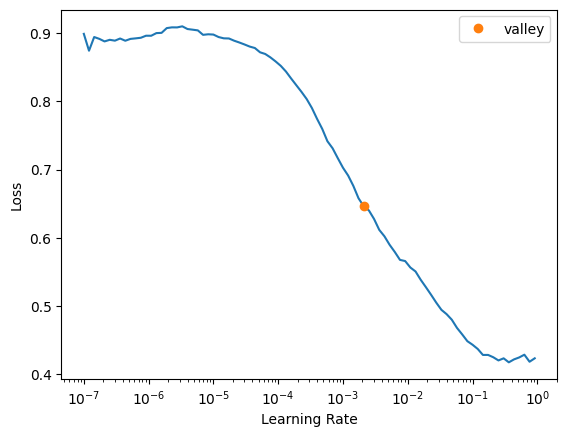

In [45]:
learn.lr_find()

In [46]:
learn.fit_one_cycle(30, 1.089e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.238233,0.191005,0.965983,00:02
1,0.194076,0.186388,0.966793,00:02
2,0.171306,0.162303,0.967063,00:02
3,0.157699,0.144702,0.967063,00:02
4,0.123347,0.141347,0.967333,00:02
5,0.137388,0.139625,0.967063,00:02
6,0.126786,0.141614,0.967333,00:02
7,0.129605,0.140100,0.967063,00:02
8,0.132469,0.138177,0.967603,00:02
9,0.129005,0.138596,0.967603,00:02


In [47]:
dl = test_dl

In [48]:
learn.save('nn_pnality_tp_pd')

Path('models/nn_pnality_tp_pd.pth')

In [49]:
#learn.load('nn_pnality_tp_pd')  

In [50]:
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)
nn_preds_proba = (a_preds[:, 1])

In [51]:
a_preds.shape

torch.Size([6175, 2])

In [52]:
nn_preds_y.shape,sub_df.shape

(torch.Size([6175, 2]), (6175, 2))

In [53]:
nn_preds_x

tensor([[0.9832, 0.0168],
        [0.9796, 0.0204],
        [0.9576, 0.0424],
        ...,
        [0.9141, 0.0859],
        [0.0288, 0.9712],
        [0.9981, 0.0019]])

In [54]:
nn_preds_y

tensor([[0.9962, 0.0038],
        [0.0221, 0.9779],
        [0.9534, 0.0466],
        ...,
        [0.9896, 0.0104],
        [0.9893, 0.0107],
        [0.0381, 0.9619]])

In [55]:
final_preds = torch.round(a_preds).long()
final_preds = final_preds[:,1]
final_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [56]:
final_preds.shape

torch.Size([6175])

In [57]:
mapping = dict(enumerate(dls.vocab))
mapping

{0: 'Extrovert', 1: 'Introvert'}

In [58]:
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in final_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


In [59]:
#!rm submission.csv
#sub_df['Personality'] = final_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv', index_col='Id')
#sub

## Gradient Boosting

### Random Forest

In [60]:
%%time
rf = RandomForestClassifier(1000, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))
rf_preds_x = tensor(rf_model.predict(X_test))

rf_score = accuracy_score(y_test,rf_preds_x)
rf_score

CPU times: user 11.2 s, sys: 79.6 ms, total: 11.3 s
Wall time: 11.3 s


0.9673326133909287

In [61]:
rf_preds

tensor([0, 1, 0,  ..., 0, 0, 1], dtype=torch.int8)

In [62]:
rf_oof_preds, rf_submission_preds, rf_mean_score, rf_fold_scores = cross_val_predict(
    model_class=RandomForestClassifier
)

Fold 1 AUC: 0.967949
Fold 2 AUC: 0.967611
Fold 3 AUC: 0.968286
Fold 4 AUC: 0.970985
Fold 5 AUC: 0.967949

Mean AUC: 0.968556


In [63]:
rf_oof_preds

array([1., 0., 0., ..., 1., 0., 0.])

In [64]:
rf_submission_preds = torch.round(torch.tensor(rf_submission_preds)).long()
rf_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [65]:
 rf_mean_score

0.9685560053981106

In [66]:
rf_fold_scores

[0.967948717948718,
 0.9676113360323887,
 0.9682860998650472,
 0.9709851551956815,
 0.967948717948718]

In [67]:
rf_oof_preds.shape, rf_submission_preds.shape, rf_mean_score

((14820,), torch.Size([6175]), 0.9685560053981106)

#### Random forest feature importance

In [68]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=True)

In [69]:
fi = rf_feat_importance(rf_model, X_train)
#fi[:10]
fi

,cols,imp
5,Friends_circle_size_na,0.000440
4,Going_outside_na,0.000779
6,Post_frequency_na,0.000858
3,Social_event_attendance_na,0.001026
2,Time_spent_Alone_na,0.001111
10,Friends_circle_size,0.040708
11,Post_frequency,0.097367
9,Going_outside,0.107287
8,Social_event_attendance,0.120412
7,Time_spent_Alone,0.167346


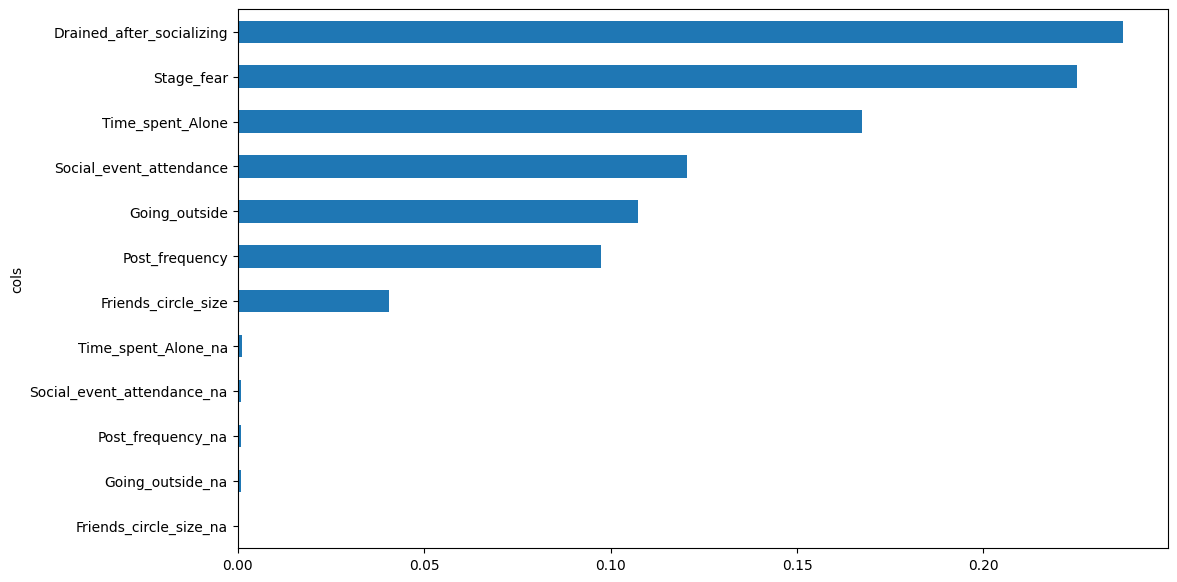

In [70]:
#feature importance visualization
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

#plot_fi(fi[:30]);
plot_fi(fi);

In [71]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in rf_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


### XGBoost

##### Single Fold¶

In [72]:
%%time
xgb_model = xgb.XGBClassifier()
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

xgb_score = accuracy_score(y_test,xgb_preds_x)
xgb_score

CPU times: user 316 ms, sys: 14.9 ms, total: 331 ms
Wall time: 203 ms


0.966792656587473

In [73]:
xgb_oof_preds, xgb_submission_preds, xgb_mean_score, xgb_fold_scores = cross_val_predict(
    model_class=xgb.XGBClassifier
)

Fold 1 AUC: 0.968286
Fold 2 AUC: 0.966599
Fold 3 AUC: 0.968286
Fold 4 AUC: 0.968286
Fold 5 AUC: 0.969298

Mean AUC: 0.968151


In [74]:
xgb_oof_preds

array([1., 0., 0., ..., 1., 0., 0.])

In [75]:
xgb_submission_preds = torch.round(torch.tensor(xgb_submission_preds)).long()
xgb_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [76]:
xgb_mean_score,xgb_fold_scores

(0.9681511470985156,
 [0.9682860998650472,
  0.9665991902834008,
  0.9682860998650472,
  0.9682860998650472,
  0.9692982456140351])

In [77]:
xgb_oof_preds.shape, xgb_submission_preds.shape, xgb_mean_score
#fold_scores.shape

((14820,), torch.Size([6175]), 0.9681511470985156)

In [78]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in xgb_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


### LGBM

In [79]:
%%time
#ds subset
lgbm_model = lgb.LGBMClassifier()
lgbm_model = lgbm_model.fit(X_train, y_train)

#test set preds
#lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))

lgbm_preds_x = tensor(lgbm_model.predict(X_test))

lgbm_score = accuracy_score(y_test,lgbm_preds_x)
lgbm_score

[LightGBM] [Info] Number of positive: 3875, number of negative: 10945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 14820, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.261471 -> initscore=-1.038337
[LightGBM] [Info] Start training from score -1.038337
CPU times: user 360 ms, sys: 26.1 ms, total: 386 ms
Wall time: 264 ms


0.966792656587473

In [80]:
lgbm_oof_preds, lgbm_submission_preds, lgbm_mean_score, lgbm_fold_scores = cross_val_predict(
    model_class=lgb.LGBMClassifier
)

[LightGBM] [Info] Number of positive: 3100, number of negative: 8756
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 11856, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.261471 -> initscore=-1.038337
[LightGBM] [Info] Start training from score -1.038337
Fold 1 AUC: 0.967274
[LightGBM] [Info] Number of positive: 3100, number of negative: 8756
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 11856, number of used features: 12
[Ligh

In [81]:
lgbm_oof_preds

array([1., 0., 0., ..., 1., 0., 0.])

In [82]:
lgbm_submission_preds = torch.round(torch.tensor(lgbm_submission_preds)).long()
lgbm_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [83]:
lgbm_mean_score,lgbm_fold_scores

(0.9686909581646423,
 [0.9672739541160594,
  0.9686234817813765,
  0.9686234817813765,
  0.9696356275303644,
  0.9692982456140351])

In [84]:
lgbm_oof_preds.shape, lgbm_submission_preds.shape, lgbm_mean_score

((14820,), torch.Size([6175]), 0.9686909581646423)

In [85]:
%%time
K_FOLDS = 10
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
lgb_fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    lgb_model_fold = lgb.LGBMClassifier()
    lgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on validation set
    y_pred_fold = lgb_model_fold.predict(X_fold_val)
    y_pred_fold_tt = lgb_model_fold.predict(test_dl.xs)
    
    # Calculate accuracy score
    lgb_cv_score = accuracy_score(y_fold_val, lgb_model_fold.predict(X_fold_val))
    lgb_fold_scores.append(lgb_cv_score)
    
    print(f"Fold {fold} AUC: {lgb_cv_score}")

lgb_mean_score = np.mean(lgb_fold_scores)
print(f"Mean AUC: {lgb_mean_score}")

[LightGBM] [Info] Number of positive: 3487, number of negative: 9851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 13338, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.261433 -> initscore=-1.038531
[LightGBM] [Info] Start training from score -1.038531
Fold 1 AUC: 0.9676113360323887
[LightGBM] [Info] Number of positive: 3487, number of negative: 9851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 13338, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.261433 ->

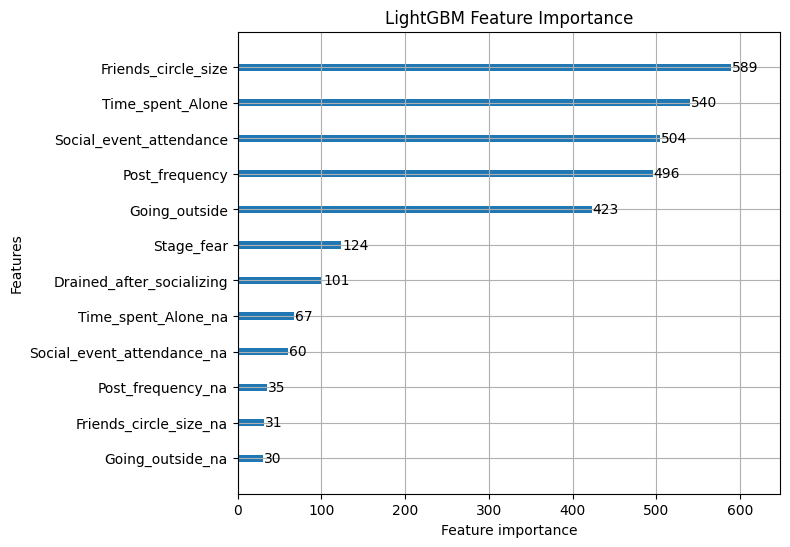

In [86]:
# Plot feature importance without using Gain or split
lgb.plot_importance(lgbm_model, figsize=(7,6), title="LightGBM Feature Importance")
#plt.title('LGBM Feature Importance')
#plt.tight_layout()
plt.show()

In [87]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in lgbm_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


### CatBoost

In [88]:
%%time
#using full ds
cat_model_params = CatBoostClassifier()
cat_model_params = cat_model_params.fit(X_train, y_train, verbose=False)


cat_preds_params = tensor(cat_model_params.predict(test_dl.xs))

cat_preds_x_params = tensor(cat_model_params.predict(X_test))

cat_score_params = accuracy_score(y_test,cat_preds_x_params)
cat_score_params

CPU times: user 14.2 s, sys: 2.85 s, total: 17.1 s
Wall time: 4.48 s


0.966792656587473

In [89]:
%%time
#using full ds
cat_model = CatBoostClassifier()
cat_model = cat_model.fit(X_train, y_train, verbose=False)


cat_preds = tensor(cat_model.predict(test_dl.xs))

cat_preds_x = tensor(cat_model.predict(X_test))

cat_score = accuracy_score(y_test,cat_preds_x)
cat_score

CPU times: user 20.2 s, sys: 4.47 s, total: 24.7 s
Wall time: 6.3 s


0.966792656587473

In [90]:
cat_oof_preds_y, cat_submission_preds_y, cat_mean_score_y, cat_fold_scores_y = cross_val_predict(
    model_class=CatBoostClassifier,
    
)

Learning rate set to 0.029615
0:	learn: 0.6449577	total: 5.24ms	remaining: 5.24s
1:	learn: 0.6009969	total: 8.64ms	remaining: 4.31s
2:	learn: 0.5607532	total: 12.9ms	remaining: 4.28s
3:	learn: 0.5230897	total: 16.6ms	remaining: 4.14s
4:	learn: 0.4891641	total: 20.2ms	remaining: 4.02s
5:	learn: 0.4585001	total: 23.7ms	remaining: 3.93s
6:	learn: 0.4303250	total: 27.6ms	remaining: 3.91s
7:	learn: 0.4048463	total: 30.9ms	remaining: 3.83s
8:	learn: 0.3815899	total: 34.5ms	remaining: 3.8s
9:	learn: 0.3610703	total: 38.5ms	remaining: 3.81s
10:	learn: 0.3417717	total: 42.4ms	remaining: 3.81s
11:	learn: 0.3242759	total: 45.9ms	remaining: 3.78s
12:	learn: 0.3082616	total: 49.7ms	remaining: 3.77s
13:	learn: 0.2936181	total: 53.9ms	remaining: 3.8s
14:	learn: 0.2810158	total: 56.7ms	remaining: 3.72s
15:	learn: 0.2689537	total: 60.4ms	remaining: 3.71s
16:	learn: 0.2573393	total: 63.9ms	remaining: 3.7s
17:	learn: 0.2478910	total: 66.5ms	remaining: 3.63s
18:	learn: 0.2384031	total: 70.1ms	remaining: 3

In [91]:
cat_score_params,cat_score

(0.966792656587473, 0.966792656587473)

In [92]:
cat_oof_preds, cat_submission_preds, cat_mean_score, cat_fold_scores = cross_val_predict(
    model_class=CatBoostClassifier
)

Learning rate set to 0.029615
0:	learn: 0.6449577	total: 4.79ms	remaining: 4.79s
1:	learn: 0.6009969	total: 8.13ms	remaining: 4.06s
2:	learn: 0.5607532	total: 12ms	remaining: 3.98s
3:	learn: 0.5230897	total: 15.7ms	remaining: 3.9s
4:	learn: 0.4891641	total: 19.4ms	remaining: 3.86s
5:	learn: 0.4585001	total: 23ms	remaining: 3.81s
6:	learn: 0.4303250	total: 26.8ms	remaining: 3.81s
7:	learn: 0.4048463	total: 30.3ms	remaining: 3.75s
8:	learn: 0.3815899	total: 34.4ms	remaining: 3.79s
9:	learn: 0.3610703	total: 38.1ms	remaining: 3.77s
10:	learn: 0.3417717	total: 42ms	remaining: 3.77s
11:	learn: 0.3242759	total: 45.9ms	remaining: 3.78s
12:	learn: 0.3082616	total: 49.8ms	remaining: 3.78s
13:	learn: 0.2936181	total: 53.4ms	remaining: 3.76s
14:	learn: 0.2810158	total: 56.2ms	remaining: 3.69s
15:	learn: 0.2689537	total: 59.9ms	remaining: 3.68s
16:	learn: 0.2573393	total: 64.6ms	remaining: 3.73s
17:	learn: 0.2478910	total: 67.4ms	remaining: 3.68s
18:	learn: 0.2384031	total: 71.2ms	remaining: 3.67s

In [93]:
cat_oof_preds

array([1., 0., 0., ..., 1., 0., 0.])

In [94]:
cat_submission_preds = torch.round(torch.tensor(cat_submission_preds)).long()
cat_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [95]:
cat_mean_score,cat_mean_score_y

(0.9685560053981106, 0.9685560053981106)

In [96]:
cat_mean_score,cat_mean_score_y

(0.9685560053981106, 0.9685560053981106)

In [97]:
cat_oof_preds.shape, cat_submission_preds.shape, cat_mean_score

((14820,), torch.Size([6175]), 0.9685560053981106)

In [98]:
%%time
K_FOLDS = 10
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
cat_fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    cat_model_fold = CatBoostClassifier()
    cat_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on validation set
    y_pred_fold = cat_model_fold.predict(X_fold_val)
    y_pred_fold_tt = cat_model_fold.predict(test_dl.xs)
    
    # Calculate accuracy score
    cat_cv_score = accuracy_score(y_fold_val, cat_model_fold.predict(X_fold_val))
    cat_fold_scores.append(cat_cv_score)
    
    print(f"Fold {fold} AUC: {cat_cv_score}")

catboost_mean_score = np.mean(cat_fold_scores)
print(f"Mean AUC: {catboost_mean_score}")

Learning rate set to 0.031142
0:	learn: 0.6419645	total: 5.18ms	remaining: 5.18s
1:	learn: 0.5952580	total: 8.96ms	remaining: 4.47s
2:	learn: 0.5535501	total: 13.2ms	remaining: 4.38s
3:	learn: 0.5146242	total: 17.1ms	remaining: 4.27s
4:	learn: 0.4798671	total: 21ms	remaining: 4.19s
5:	learn: 0.4484795	total: 24.9ms	remaining: 4.12s
6:	learn: 0.4198320	total: 28.8ms	remaining: 4.08s
7:	learn: 0.3939840	total: 32.5ms	remaining: 4.02s
8:	learn: 0.3705993	total: 36.4ms	remaining: 4s
9:	learn: 0.3501098	total: 40.5ms	remaining: 4s
10:	learn: 0.3308741	total: 44.5ms	remaining: 4s
11:	learn: 0.3133656	total: 48.4ms	remaining: 3.99s
12:	learn: 0.2974975	total: 52.4ms	remaining: 3.98s
13:	learn: 0.2830366	total: 56.4ms	remaining: 3.97s
14:	learn: 0.2707427	total: 59.8ms	remaining: 3.92s
15:	learn: 0.2590172	total: 63.9ms	remaining: 3.93s
16:	learn: 0.2477242	total: 67.9ms	remaining: 3.93s
17:	learn: 0.2385965	total: 70.9ms	remaining: 3.87s
18:	learn: 0.2294712	total: 75ms	remaining: 3.87s
19:	l

In [99]:
feature_importance = cat_model.get_feature_importance()
feature_names = train_df.columns

# Display feature importance
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: Time_spent_Alone, Importance: 7.84
Feature: Stage_fear, Importance: 7.63
Feature: Social_event_attendance, Importance: 1.89
Feature: Going_outside, Importance: 1.84
Feature: Drained_after_socializing, Importance: 1.13
Feature: Friends_circle_size, Importance: 0.62
Feature: Post_frequency, Importance: 1.28
Feature: Personality, Importance: 14.25


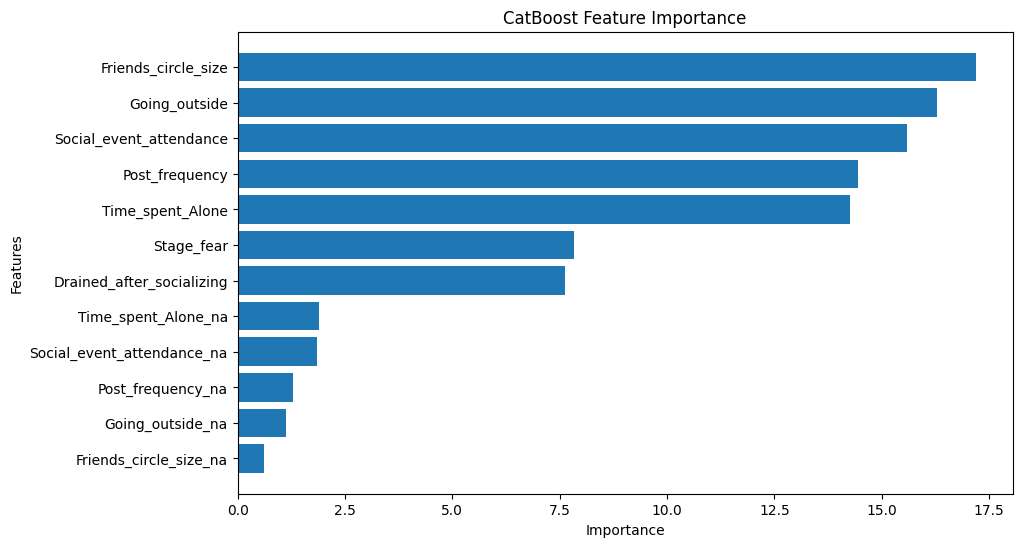

In [100]:
#importances = cat_model.get_feature_importance(type='PredictionValuesChange')
importances = cat_model.get_feature_importance()
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [101]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in cat_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


## Ensembling

For better results, we can try combining the results from various models. 

Different models make different types of errors, meaning the different types of models will possibly be wrong in different ways and on different samples. So averaging the different predictions should in theory help reduce the error rate. We experiment with this below.

First we shall start off by trying simple averaging.

### Averaging

First, let us check the shape of the predictions for our various modes to confirm they match

In [102]:
final_preds.shape,rf_preds.shape, xgb_preds.shape, lgbm_preds.shape, cat_preds.shape

(torch.Size([6175]),
 torch.Size([6175]),
 torch.Size([6175]),
 torch.Size([6175]),
 torch.Size([6175]))

In [103]:
final_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [104]:
rf_preds

tensor([0, 1, 0,  ..., 0, 0, 1], dtype=torch.int8)

In [105]:
xgb_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [106]:
cat_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [107]:
lgbm_preds

tensor([0, 1, 0,  ..., 0, 0, 1], dtype=torch.int8)

In [108]:
def average_preds_sub(*preds):
    """
    A function to return the average predictions of 2 different models
    First it sums up all the predictions, divides by number of models,
    rounds off the values returning float values,
    Lastly it converts them to int long type
    """
    average_preds_sub = (torch.round(sum(preds)/len(preds))).long()
    return average_preds_sub

In [109]:
def average_preds_score(*preds,y_test):
    """
    A function to calculate the accuracy of the average predictions of 2 different models
    First it sums up the predictions,divides by the number of models,
    then rounds off the values to float,
    It then turns our float values into integers, 
    Lastly it calculates the accuracy of the average of the predictions
    """
    average_preds = (torch.round(sum(preds)/len(preds))).long()
    preds_score = accuracy_score(y_test,average_preds)
    print(f"Average_score:{preds_score}")
    return preds_score

In [110]:
#catBoost + Neural Network
cat_nn_preds = average_preds_sub(final_preds, cat_preds)
cat_nn_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [111]:
#catBoost + Neural Network average score
#cat_nn_score = average_preds_score(final_preds, cat_preds)
#cat_nn_score

In [112]:
#Random forest + Neural Network
rf_nn_preds = average_preds_sub(final_preds, rf_preds)
#I havent yet created predictions on the y-test to the same size as rf_preds_x  
#so ill leave our scoring the rf + nn ensembles for now
#rf_nn_score = average_preds_score(final_preds_x, rf_preds, y_test=y_test)
#rf_nn_score, 
rf_nn_preds



tensor([0, 1, 0,  ..., 0, 0, 1])

In [113]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in rf_nn_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


In [114]:
#LGBM + Neural Network
lgbm_nn_preds = average_preds_sub(final_preds, lgbm_preds)
#lgbm_nn_score = average_preds_score(final_preds_x, lgbm_preds, y_test=y_test)
#lgbm_nn_score, 
lgbm_nn_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [115]:
#XGBoost + Neural Network
xgb_nn_preds = average_preds_sub(final_preds, xgb_preds)
#xgb_nn_score = average_preds_score(final_preds_x, xgb_preds_x, y_test=y_test)
#xgb_nn_score, 
xgb_nn_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

##### 3 Models

#### Stacking

In [116]:
stacking_estimators = [
    ('cat_boost',cat_model),
    #('rf',rf_model),
    ('lgbm',lgbm_model),
    ('xgb',xgb_model),
]

#stacking_classifier_cat_xgb_lgbm= StackingClassifier(
    #estimators=stacking_estimators,
    #final_estimator=LogisticRegression(),
    #cv=5
#)
stacking_classifier_cat_lgbm= StackingClassifier(
    estimators=stacking_estimators,
    final_estimator=lgb.LGBMClassifier(**lgbm_params),
    cv=5
)
stacking_classifier_cat_lgbm.fit(X_train, y_train)


stacking_preds_cat_lgbm = (stacking_classifier_cat_lgbm.predict(test_dl.xs))
stacking_preds_cat_lgbm_x = (stacking_classifier_cat_lgbm.predict(X_test))

stacking_score_cat_lgbm = accuracy_score(y_test, stacking_preds_cat_lgbm_x)

print(f"Final Stacking Classifier Accuracy on test set: {stacking_score_cat_lgbm}")

Learning rate set to 0.032575
0:	learn: 0.6402371	total: 5.78ms	remaining: 5.77s
1:	learn: 0.5924899	total: 9.69ms	remaining: 4.84s
2:	learn: 0.5492694	total: 14.6ms	remaining: 4.84s
3:	learn: 0.5089563	total: 19ms	remaining: 4.72s
4:	learn: 0.4731532	total: 23.1ms	remaining: 4.6s
5:	learn: 0.4410180	total: 27ms	remaining: 4.47s
6:	learn: 0.4119430	total: 31ms	remaining: 4.4s
7:	learn: 0.3857493	total: 34.6ms	remaining: 4.29s
8:	learn: 0.3621750	total: 38.7ms	remaining: 4.26s
9:	learn: 0.3415725	total: 42.7ms	remaining: 4.23s
10:	learn: 0.3222913	total: 47.3ms	remaining: 4.25s
11:	learn: 0.3049848	total: 52ms	remaining: 4.28s
12:	learn: 0.2893071	total: 56.1ms	remaining: 4.26s
13:	learn: 0.2750041	total: 60.3ms	remaining: 4.24s
14:	learn: 0.2629145	total: 63.5ms	remaining: 4.17s
15:	learn: 0.2514650	total: 67.8ms	remaining: 4.17s
16:	learn: 0.2404069	total: 72.5ms	remaining: 4.19s
17:	learn: 0.2315600	total: 75.6ms	remaining: 4.12s
18:	learn: 0.2228094	total: 79.7ms	remaining: 4.12s
19

In [117]:
print(f"Final Stacking Classifier Accuracy on test set: {stacking_score_cat_lgbm}")

Final Stacking Classifier Accuracy on test set: 0.966792656587473


In [118]:
stacking_preds_cat_lgbm.shape

(6175,)

In [119]:
stacking_preds_cat_lgbm

array([0, 1, 0, ..., 0, 0, 1], dtype=int8)

In [120]:
stacking_preds_cat_lgbm = torch.tensor(stacking_preds_cat_lgbm)

In [121]:
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in stacking_preds_cat_lgbm]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


In [122]:
#!rm submission.csv
#sub_df['Personality'] = stacking_preds_cat_xgb_lgbm
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

#### Voting

In [123]:
%%time
# Assuming rf_model,xgb_model etc. *are already fitted models
# Wrap them in a VotingClassifier
voting_clf = VotingClassifier(estimators=[
    #('rf', rf_model),  
    ('xgb', xgb_model),  
    ('cat', cat_model),  
    ('lgb', lgbm_model)
    #('nn', nn_model)
], voting='soft')



voting_clf.fit(X_train, y_train)

voting_predictions = voting_clf.predict(test_dl.xs)
voting_predictions_x = voting_clf.predict(X_test)

# Calculate the accuracy score
voting_accuracy_soft = accuracy_score(y_test, voting_predictions_x)
#print(f"Accuracy: {voting_accuracy:.6f}")

Learning rate set to 0.032575
0:	learn: 0.6402371	total: 5.06ms	remaining: 5.06s
1:	learn: 0.5924899	total: 8.72ms	remaining: 4.35s
2:	learn: 0.5492694	total: 12.9ms	remaining: 4.29s
3:	learn: 0.5089563	total: 17ms	remaining: 4.23s
4:	learn: 0.4731532	total: 21.2ms	remaining: 4.22s
5:	learn: 0.4410180	total: 25.3ms	remaining: 4.19s
6:	learn: 0.4119430	total: 29.2ms	remaining: 4.15s
7:	learn: 0.3857493	total: 32.9ms	remaining: 4.08s
8:	learn: 0.3621750	total: 37ms	remaining: 4.08s
9:	learn: 0.3415725	total: 41ms	remaining: 4.05s
10:	learn: 0.3222913	total: 44.9ms	remaining: 4.03s
11:	learn: 0.3049848	total: 48.8ms	remaining: 4.02s
12:	learn: 0.2893071	total: 53.4ms	remaining: 4.06s
13:	learn: 0.2750041	total: 57.6ms	remaining: 4.05s
14:	learn: 0.2629145	total: 60.7ms	remaining: 3.99s
15:	learn: 0.2514650	total: 64.8ms	remaining: 3.98s
16:	learn: 0.2404069	total: 68.7ms	remaining: 3.97s
17:	learn: 0.2315600	total: 71.9ms	remaining: 3.92s
18:	learn: 0.2228094	total: 76.2ms	remaining: 3.93

In [124]:
voting_accuracy_soft

0.9673326133909287

In [125]:
voting_predictions.shape

(6175,)

In [126]:
voting_predictions = torch.tensor(voting_predictions)
voting_predictions

tensor([0, 1, 0,  ..., 0, 0, 1], dtype=torch.int8)

In [127]:
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in voting_predictions]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


##### Voting - Hard

In [128]:
%%time
# Assuming rf_model,xgb_model etc. *are already fitted models
# Wrap them in a VotingClassifier
voting_clf_hard = VotingClassifier(estimators=[
    #('rf', rf_model),  
    ('xgb', xgb_model),  
    ('cat', cat_model),  
    ('lgb', lgbm_model)
    #('nn', nn_model)
], voting='hard')



voting_clf_hard.fit(X_train, y_train)

voting_predictions_hard = voting_clf_hard.predict(test_dl.xs)
voting_predictions_hard_x = voting_clf_hard.predict(X_test)

# Calculate the accuracy score
voting_accuracy_hard = accuracy_score(y_test, voting_predictions_hard_x)
print(f"Accuracy: {voting_accuracy_hard:.6f}")

Learning rate set to 0.032575
0:	learn: 0.6402371	total: 5.26ms	remaining: 5.25s
1:	learn: 0.5924899	total: 9.09ms	remaining: 4.54s
2:	learn: 0.5492694	total: 13.5ms	remaining: 4.49s
3:	learn: 0.5089563	total: 17.8ms	remaining: 4.44s
4:	learn: 0.4731532	total: 21.8ms	remaining: 4.34s
5:	learn: 0.4410180	total: 26.1ms	remaining: 4.32s
6:	learn: 0.4119430	total: 30ms	remaining: 4.26s
7:	learn: 0.3857493	total: 33.8ms	remaining: 4.19s
8:	learn: 0.3621750	total: 38.1ms	remaining: 4.2s
9:	learn: 0.3415725	total: 41.9ms	remaining: 4.15s
10:	learn: 0.3222913	total: 46.2ms	remaining: 4.15s
11:	learn: 0.3049848	total: 50.1ms	remaining: 4.13s
12:	learn: 0.2893071	total: 54.2ms	remaining: 4.11s
13:	learn: 0.2750041	total: 58.4ms	remaining: 4.12s
14:	learn: 0.2629145	total: 61.5ms	remaining: 4.04s
15:	learn: 0.2514650	total: 65.9ms	remaining: 4.05s
16:	learn: 0.2404069	total: 70.3ms	remaining: 4.06s
17:	learn: 0.2315600	total: 74.3ms	remaining: 4.05s
18:	learn: 0.2228094	total: 79.1ms	remaining: 4

In [129]:
print(f"Accuracy: {voting_accuracy_hard:.6f}")

Accuracy: 0.967333


#### Hill Climbing

In [130]:
# Get class predictions for only CatBoost and LightGBM
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
cat_preds = tensor(cat_model.predict(test_dl.xs))

# Validation predictions
lgbm_valid_preds = tensor(lgbm_model.predict(X_test))
cat_valid_preds = tensor(cat_model.predict(X_test))

# Create validation DataFrame for hill climbing
valid_ensemble = pd.DataFrame({
    'lgbm': lgbm_valid_preds,
    'cat': cat_valid_preds
})

# Create test DataFrame for hill climbing
test_ensemble = pd.DataFrame({
    'lgbm': lgbm_preds,
    'cat': cat_preds
})

def climb_hill(train_preds, test_preds, y_true, precision=0.001, max_iter=1000):
    n_models = train_preds.shape[1]
    weights = np.ones(n_models) / n_models  # Start with equal weights
    
    # For class predictions, round the weighted sum
    best_preds = np.round(train_preds @ weights).astype(int)
    best_score = accuracy_score(y_true, best_preds)
    improved = True
    iter_count = 0
    
    while improved and iter_count < max_iter:
        improved = False
        iter_count += 1
        
        for i in range(n_models):
            # Try increasing weight
            new_weights = weights.copy()
            new_weights[i] += precision
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
                continue
                
            # Try decreasing weight
            new_weights = weights.copy()
            new_weights[i] = max(0, new_weights[i] - precision)
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
    
    # Get final predictions for both validation and test
    valid_preds = np.round(train_preds @ weights).astype(int)
    test_preds = np.round(test_preds @ weights).astype(int)
    
    return valid_preds, test_preds, weights, best_score

# Apply hill climbing
valid_preds, optimized_test_preds, final_weights, best_score = climb_hill(
    valid_ensemble.values, 
    test_ensemble.values, 
    y_test
)

print(f"Optimized weights: {final_weights}")
print(f"Best validation accuracy: {best_score}")

# Compare scores
print("\nModel Scores:")
print(f"LightGBM: {lgbm_score}")
print(f"CatBoost: {cat_score}")
print(f"Hill Climbing Ensemble: {best_score}")

# Create submission with optimized predictions
#sub_df['Depression'] = optimized_test_preds
#sub_df.to_csv('submission.csv', index=False)

Optimized weights: [0.5 0.5]
Best validation accuracy: 0.9670626349892009

Model Scores:
LightGBM: 0.966792656587473
CatBoost: 0.966792656587473
Hill Climbing Ensemble: 0.9670626349892009


## Ranking

In [131]:
accuracy = pd.DataFrame({
    'algorithm': ['Random Forest',
                  'RF CV','XGBoost','XGBoost CV','LGBM','LGBM CV','CatBoost','CatBoost CV',
                  
                 ],
    'accuracy': [rf_mean_score,rf_score,xgb_score,xgb_mean_score,lgbm_score,
                 lgbm_mean_score,cat_score,cat_mean_score,
                 
           ]
})

accuracy_sorted = accuracy.sort_values(by='accuracy', ascending=False)
accuracy_sorted

,algorithm,accuracy
5,LGBM CV,0.968691
0,Random Forest,0.968556
7,CatBoost CV,0.968556
3,XGBoost CV,0.968151
1,RF CV,0.967333
2,XGBoost,0.966793
4,LGBM,0.966793
6,CatBoost,0.966793
